# Subject Model Sandbox

This notebook provides an example for how to use the SubjectModel outside of the AI Architecture.  The saved cell outputs use Clintek 21 (a muscular dystrophy trial) as an example. First, we need to import the source code into our notebook:

In [1]:
import sys
import pandas as pd
sys.path.append('../src/classes')

from recordcollection import RecordCollection
from dataset import AuditDataset, QueryDataset
from ordinalencodercollection import OrdinalEncoderCollection
from model import SubjectModel
from datageneratorfactory import DataGeneratorFactory
from datawindow import DataWindow

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Next, paths to the Audit, Query, and Metadata are specified.  The recommended location to save data is the `data/raw` directory of the repository.

In [2]:
path_to_audit = "../data/raw/c21_audit.csv"
path_to_query = "../data/raw/c21_query.csv"
path_to_metadata = "../data/raw/c21_metadata.csv"

With the relative paths defined, the Audit and Query data can be loaded into a `Dataset` object.  The `Dataset` is a class wrapper around a `pandas DataFrame`, the additional methods filter out irrelevant audit data (such as "Verify" AuditSubCategoryType events, etc.). The `Dataset` object is designed to interface with the `RecordCollection` object.

In [3]:
audit = AuditDataset(path = path_to_audit) 
dates = audit.dataset.groupby("ItemGroupRecordId").DateTimeStamp.min()

The above code computes the creation date of all the Audit data, and the data input timeline is shown below

SFL style loaded...


Text(0.5, 1.0, 'Clintek 21: DMD')

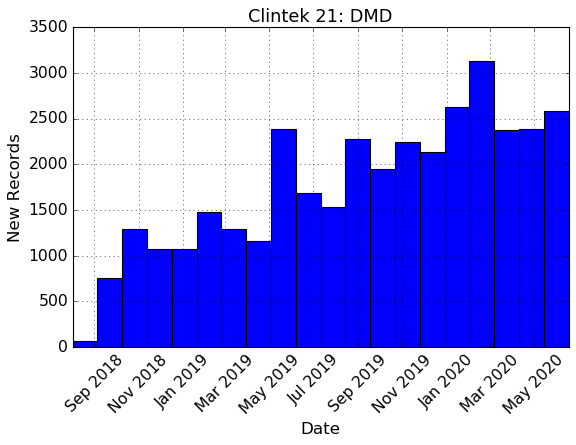

In [4]:
import matplotlib.pyplot as plt

def sfl_defaults():
	plt.style.use('classic')
	plt.rcParams['figure.figsize'] = [8.0, 5.0]
	plt.rcParams['figure.facecolor']='w'

	# text size
	plt.rcParams['xtick.labelsize']=14
	plt.rcParams['ytick.labelsize']=14
	plt.rcParams['axes.labelsize']=15
	plt.rcParams['axes.titlesize']=16
	plt.rcParams['legend.fontsize']=12

	# grids
	plt.rcParams['grid.color'] = 'k'
	plt.rcParams['grid.linestyle'] = ':'
	plt.rcParams['grid.linewidth'] = 0.5

	# 
	print('SFL style loaded...')
    
sfl_defaults()
dates = pd.to_datetime(dates)
dates.hist(bins=20)
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("New Records")
plt.title("Clintek 21: DMD")

For the in situ testing, we'll do a first model train when 30% of the available data has been uploaded:

In [37]:
first_train = dates.iloc[int(.2*dates.shape[0])]
last_train = dates.iloc[int(.9*dates.shape[0])]

print(first_train)
print(last_train)

2019-03-29 14:38:26
2020-05-08 12:38:55


Changing the `num_trains` variable controls how often the model is retrained:

In [38]:
import pickle as dill
with open("configs.pkl", "rb") as file:
    load = dill.load(file)

study_name = "Clintek_21"
config = load[study_name]

num_layers = config["num_layers"]
num_epochs = config["num_epochs"]

first_train = pd.to_datetime(config["first_train"])
last_train = pd.to_datetime(config["last_train"])
num_trains = config["num_trains"]

# The num_runs variable is used to train the model multiple times per step, set to 1 to avoid
num_runs = 1

step = (last_train - first_train) / (num_trains - 1)
step

Timedelta('58 days 00:00:00')

The following code runs sequential model trainings, the time elapsed between model trainings is controlled by the `step` variable

In [39]:
# Initialize empty lists for saving the RecordCollection, EncoderCollection, and Model objects
record_collections = []
encoder_collections = []
train_generators = []
validation_generators = []
models = []

# Initialize the first training date
train_date = first_train

for train_idx in range(num_trains):
    # Fetch the Audit and Query data
    train_audit = AuditDataset(path = path_to_audit)
    train_query = QueryDataset(path = path_to_query)
    
    # The filter_on_date method filters out rows of the Query and Audit tables that occur after the passed date
    train_audit.filter_on_date(str(train_date))
    train_query.filter_on_date(str(train_date))
    
    # Initialize a new RecordCollection
    train_record_collection = RecordCollection()
    
    # Generate the manifest (a table of record information)
    train_record_collection.make_manifest(train_audit)
    
    # Initialize empty records
    train_record_collection.initialize_records()
    
    # Populate the empty records with all available information
    train_record_collection.make_records(train_audit, train_query)
    
    # Add the train_record_collection to the record collection list
    record_collections.append(train_record_collection)
    
    print(train_date)
    
    # The get_modeling_paramters method returns a 3-tuple of information:
    #     0: a dictionary whose keys are ItemOIDs and whose values are sets of all values seen for that ItemOID
    #     1: a sorted list of the 128 most queried ItemOIDs
    #     2: a dictionary whose keys are the 128 most queried ItemOIDs and whose values are the datatype of the ItemOIDs (taken from the metadata)
    (itemoid_values, sorted_itemoids, sorted_itemoids_to_dtype) = train_record_collection.get_modeling_parameters(path_to_metadata)
    
    # Generate an encoder collection
    encoder_collection = OrdinalEncoderCollection(items_to_dtype=sorted_itemoids_to_dtype)
    
    # Fit the encoder, this assigns integer values to the data by tokenizing (text data) or binning (datetime and numerical data)
    encoder_collection.fit(itemoid_values)
    
    # Add the new encoder collection to the list
    encoder_collections.append(encoder_collection)
    
    # Define the model parameters
    window_size = 20
    split_date = train_date - pd.Timedelta("30d")
    split_date = str(split_date)

    # The DataGenerator object creates the subject snapshots and splits the data using the split date and randomly selects 30% of subjects for a temporal & subject holdout
    generator_factory = DataGeneratorFactory(train_record_collection, encoder_collection, sorted_itemoids, split_date=split_date,subject_split=.3)
    
    # Create a dictionary whose keys are ItemOIDs and whose values are the number of tokens/bins, this is used to create the embedding vocabularies
    feature_dict = generator_factory.count_feature_values()
    train_generator, validation_generator = generator_factory.make_data_generators()
    
    train_generators.append(train_generator)
    validation_generators.append(validation_generator)
    
    temp_model_list = []
    
    for run_idx in range(num_runs):
        print(f"Executing {train_idx+1, run_idx+1}")
        # Instantiate a model object and build the model
        model = SubjectModel()
        model.build_model(feature_dict, base_filters=num_layers)

        # Train the model
        model.train(train_generator, validation_generator=validation_generator, epochs=num_epochs)
        temp_model_list.append(model)
        
    # Add the model to the list
    models.append(temp_model_list)

    # Advance the train date
    train_date += step

2019-03-29 00:00:00
9
Executing (1, 1)
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 18 steps, validate for 10 steps
Epoch 1/20
18/18 - 24s - loss: 0.2961 - accuracy: 0.8918 - recall_8: 0.4069 - precision_8: 0.1950 - f1_metric: 0.3603 - val_loss: 0.4736 - val_accuracy: 0.9543 - val_recall_8: 0.0000e+00 - val_precision_8: 0.0000e+00 - val_f1_metric: 0.0000e+00
Epoch 2/20
18/18 - 3s - loss: 0.1007 - accuracy: 0.9641 - recall_8: 0.4841 - precision_8: 0.6712 - f1_metric: 0.5331 - val_loss: 0.3781 - val_accuracy: 0.9543 - val_recall_8: 0.0000e+00 - val_precision_8: 0.0000e+00 - val_f1_metric: 0.0000e+00
Epoch 3/20
18/18 - 3s - loss: 0.0740 - accuracy: 0.9749 - recall_8: 0.6179 - precision_8: 0.8088 - f1_metric: 0.6905 - val_loss: 0.3251 - val_accuracy: 0.9543 - val_recall_8: 0.0000e+00 - val_precision_8: 0.0000e+00 - val_f1_metric: 0.0000e+00
Epoch 4/20
18/18 - 3s - loss: 0.0590 - accuracy: 0.9807 - recall_8: 0.6861 - precision_8: 0.8819 - f1_metric: 0.7697 - val_loss: 0.2923 

The next cell computes the accuracy, precision, recall and F1 scores for the model across the expanding window training session. A 95% confidence interval is computed for each metric using a bootstrap approximation.

In [40]:
import numpy as np
model_performance = []

def confidence_intervals(matrix, col_id, power=.05):
    mean = matrix[:, col_id].mean()
    lower = np.quantile(matrix[:, col_id], 1-power/2)
    upper = np.quantile(matrix[:, col_id], power/2)
    return 2*mean - lower, mean, 2*mean - upper

for idx in range(num_trains):
    temp_records = record_collections[idx]
    _ , items , _ = temp_records.get_modeling_parameters(path_to_metadata)
    
    num_records = len(temp_records.records)
    num_positive = sum([any(sum(record.candidate_labels.values(),[])) for record in temp_records.records.values() if record.get_items().intersection(set(items))])
    
    temp_generator = validation_generators[idx]
    
    for model in models[idx]:
        temp_model = model

        scores = []

        for _ in range(100):
            X_batch, Y_batch = temp_generator.__getitem__(0)

            score = temp_model.model.evaluate(X_batch, Y_batch, verbose=0)
            scores.append(score)

            temp_generator.on_epoch_end()

        scores = np.asarray(scores)
        acc_low, acc_mean, acc_high = confidence_intervals(scores, 1)
        rec_low, rec_mean, rec_high = confidence_intervals(scores, 2)
        prec_low, prec_mean, prec_high = confidence_intervals(scores, 3)
        f1_low, f1_mean, f1_high = confidence_intervals(scores, 4)

        temp_dict = {"acc_low":acc_low,"acc_mean":acc_mean,"acc_high":acc_high,
                     "rec_low":rec_low,"rec_mean":rec_mean,"rec_high":rec_high,
                     "prec_low":prec_low,"prec_mean":prec_mean,"prec_high":prec_high,
                     "f1_low":f1_low,"f1_mean":f1_mean,"f1_high":f1_high,
                     "records":num_records, "positive":num_positive, "train_step":idx}
        model_performance.append(temp_dict)
        
model_performance = pd.DataFrame(model_performance)

Model performance is saved in a Pandas dataframe:

In [41]:
model_performance

acc_low  acc_mean  acc_high   rec_low  rec_mean  rec_high  prec_low  \
0  0.945226  0.953975  0.962599 -0.000589  0.000834  0.001667  0.620000   
1  0.952892  0.959730  0.965445  0.044735  0.060760  0.074999  0.669133   
2  0.965035  0.970250  0.976426  0.579563  0.625523  0.667391  0.806182   
3  0.962674  0.970172  0.977749  0.750431  0.797409  0.835802  0.844290   
4  0.975993  0.980117  0.984775  0.742406  0.788888  0.839166  0.845771   
5  0.973658  0.978768  0.983182  0.684404  0.730493  0.787636  0.851294   
6  0.968270  0.971663  0.975926  0.633260  0.683839  0.750159  0.762895   
7  0.969054  0.972205  0.976115  0.720770  0.751764  0.789216  0.686005   

   prec_mean  prec_high    f1_low   f1_mean   f1_high  records  positive  \
0   0.810000   1.620000 -0.001172  0.001665  0.003330     6877       476   
1   0.785306   0.923021  0.065330  0.111718  0.150655     9386       624   
2   0.847291   0.892195  0.679549  0.719740  0.760385    12674       863   
3   0.871588   0.898039  0.795330  0.831757  0.875980    16208      1155   
4   0.877927   0.911412  0.790403  0.830037  0.869740    19748      1352   
5   0.879107   0.910707  0.758513  0.796623  0.833403    23492      1612   
6   0.799074   0.834218  0.672285  0.728985  0.826562    28362      1945   
7   0.724325   0.762308  0.706672  0.736840  0.766987    32502      2185   

   train_step  
0           0  
1           1  
2           2  
3           3  
4           4  
5           5  
6           6  
7           7

The following cells generate the plots shown in the generalizability analysis:

In [ ]:
reference_performance = pd.read_csv("../data/processed/reference_performance.csv")
reference_performance = reference_performance[reference_performance.Study == "Clintek 20"]

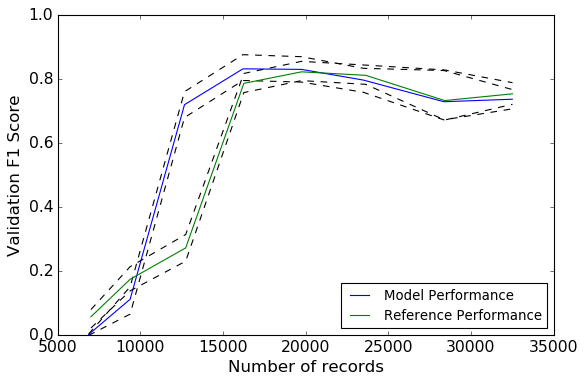

In [44]:
model_performance.set_index("records")["f1_mean"].plot(label="Model Performance")
model_performance.set_index("records")["f1_low"].plot(style="k--", label="")
model_performance.set_index("records")["f1_high"].plot(style="k--", label="")

reference_performance.groupby("train_step").mean().set_index("records")["f1_mean"].plot(label="Reference Performance")
reference_performance.groupby("train_step").mean().set_index("records")["f1_low"].plot(style="k--", label="")
reference_performance.groupby("train_step").mean().set_index("records")["f1_high"].plot(style="k--", label="")

plt.xlabel("Number of records")
plt.ylabel("Validation F1 Score")
plt.ylim([0,1])
plt.legend(loc="lower right")

Plot an example source snapshot:

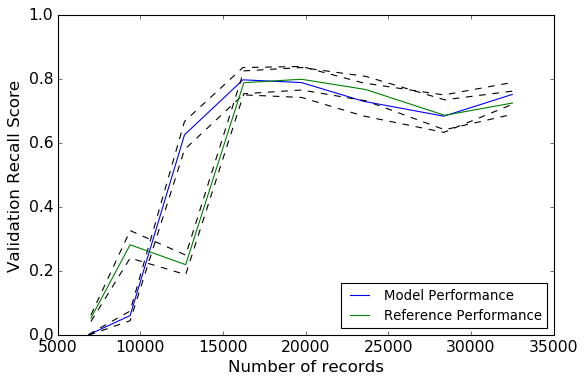

In [47]:
model_performance.set_index("records")["rec_mean"].plot(label="Model Performance")
model_performance.set_index("records")["rec_low"].plot(style="k--", label="")
model_performance.set_index("records")["rec_high"].plot(style="k--", label="")

reference_performance.groupby("train_step").mean().set_index("records")["rec_mean"].plot(label="Reference Performance")
reference_performance.groupby("train_step").mean().set_index("records")["rec_low"].plot(style="k--", label="")
reference_performance.groupby("train_step").mean().set_index("records")["rec_high"].plot(style="k--", label="")

plt.xlabel("Number of records")
plt.ylabel("Validation Recall Score")
plt.ylim([0,1])
plt.legend(loc="lower right")

(0, 1)

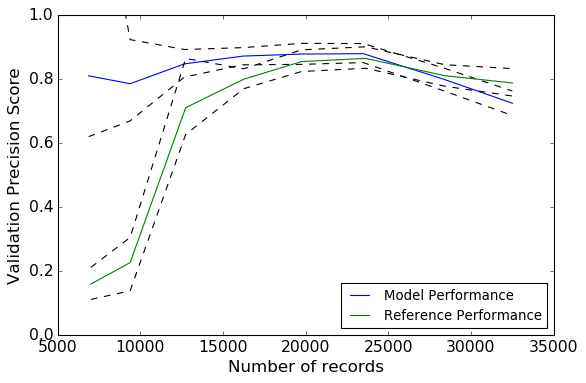

In [46]:
model_performance.set_index("records")["prec_mean"].plot(label="Model Performance")
model_performance.set_index("records")["prec_low"].plot(style="k--", label="")
model_performance.set_index("records")["prec_high"].plot(style="k--", label="")

reference_performance.groupby("train_step").mean().set_index("records")["prec_mean"].plot(label="Reference Performance")
reference_performance.groupby("train_step").mean().set_index("records")["prec_low"].plot(style="k--", label="")
reference_performance.groupby("train_step").mean().set_index("records")["prec_high"].plot(style="k--", label="")

plt.xlabel("Number of records")
plt.ylabel("Validation Precision Score")
plt.legend(loc="lower right")
plt.ylim([0,1])

(0, 1)

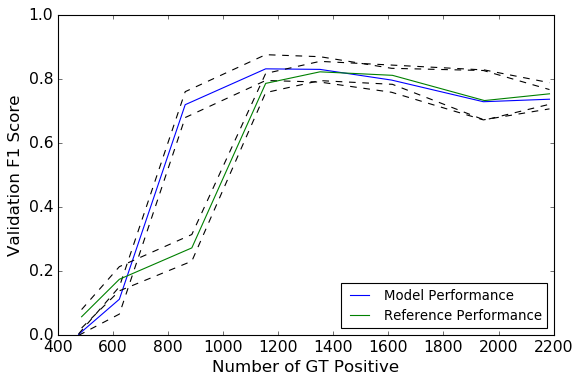

In [48]:
model_performance.set_index("positive")["f1_mean"].plot(label="Model Performance")
model_performance.set_index("positive")["f1_low"].plot(style="k--", label="")
model_performance.set_index("positive")["f1_high"].plot(style="k--", label="")

reference_performance.groupby("train_step").mean().set_index("positive")["f1_mean"].plot(label="Reference Performance")
reference_performance.groupby("train_step").mean().set_index("positive")["f1_low"].plot(style="k--", label="")
reference_performance.groupby("train_step").mean().set_index("positive")["f1_high"].plot(style="k--", label="")

plt.xlabel("Number of GT Positive")
plt.ylabel("Validation F1 Score")
plt.legend(loc="lower right")
plt.ylim([0,1])

(0, 1)

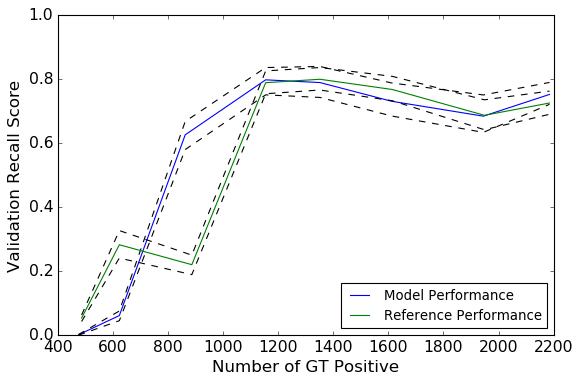

In [49]:
model_performance.set_index("positive")["rec_mean"].plot(label="Model Performance")
model_performance.set_index("positive")["rec_low"].plot(style="k--", label="")
model_performance.set_index("positive")["rec_high"].plot(style="k--", label="")

reference_performance.groupby("train_step").mean().set_index("positive")["rec_mean"].plot(label="Reference Performance")
reference_performance.groupby("train_step").mean().set_index("positive")["rec_low"].plot(style="k--", label="")
reference_performance.groupby("train_step").mean().set_index("positive")["rec_high"].plot(style="k--", label="")

plt.xlabel("Number of GT Positive")
plt.ylabel("Validation Recall Score")
plt.legend(loc="lower right")
plt.ylim([0,1])

(0, 1)

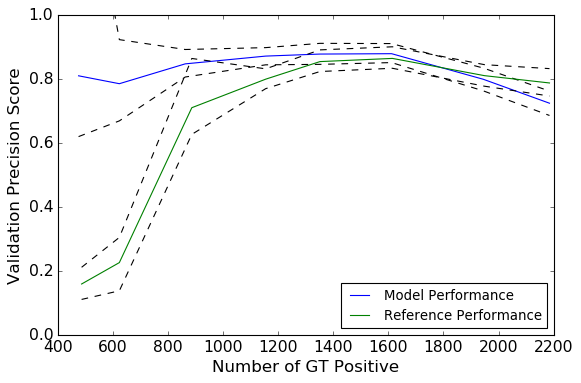

In [50]:
model_performance.set_index("positive")["prec_mean"].plot(label="Model Performance")
model_performance.set_index("positive")["prec_low"].plot(style="k--", label="")
model_performance.set_index("positive")["prec_high"].plot(style="k--", label="")

reference_performance.groupby("train_step").mean().set_index("positive")["prec_mean"].plot(label="Reference Performance")
reference_performance.groupby("train_step").mean().set_index("positive")["prec_low"].plot(style="k--", label="")
reference_performance.groupby("train_step").mean().set_index("positive")["prec_high"].plot(style="k--", label="")

plt.xlabel("Number of GT Positive")
plt.ylabel("Validation Precision Score")
plt.legend(loc="lower right")
plt.ylim([0,1])

In [51]:
source_test_data = validation_generator.source_snapshots
target_test_data = validation_generator.target_snapshots
record_test_data = validation_generator.record_snapshots

Text(0, 0.5, 'ItemOID ID')

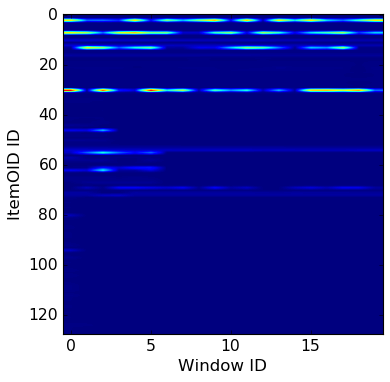

In [52]:
plt.imshow(source_test_data[0,:,:,0],aspect=20/128)
plt.xlabel("Window ID")
plt.ylabel("ItemOID ID")

Plot an exmaple target snapshot:

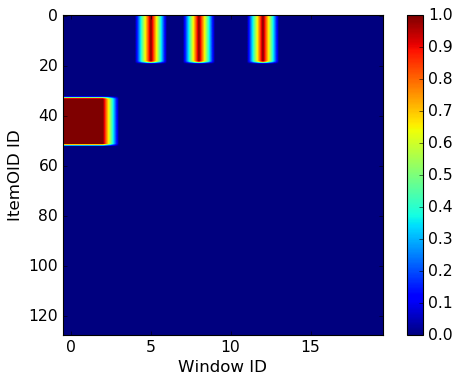

In [53]:
plt.imshow(target_test_data[0,:,:,0],aspect=20/128)
plt.xlabel("Window ID")
plt.ylabel("ItemOID ID")
plt.colorbar()

The `infer.py` file in the `src/` directory contains the code used to generate the data risk score for each record. First, the model is used to predict the labels of the tetsing data:

In [20]:
model_predictions = model.infer(source_test_data)

Plot an example of the model prediction (should resemble the above target snapshot)

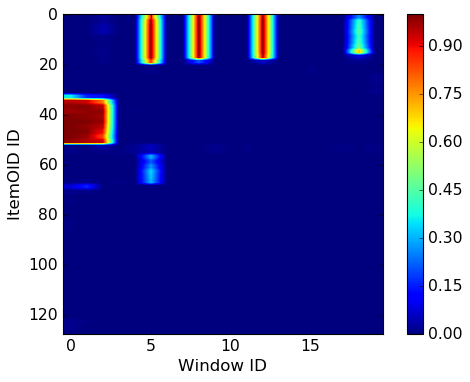

In [54]:
plt.imshow(model_predictions[0,:,:,0],aspect=20/128)
plt.xlabel("Window ID")
plt.ylabel("ItemOID ID")
plt.colorbar()

To generate the aggregated risk score of the records (at the ItemOID level) in the snapshot, use the `assess_batch` method of the model:

In [55]:
predicted_record_scores = pd.DataFrame(model.assess_batch(validation_generator))

In [56]:
predicted_record_scores.head(10)

ItemGroupRecordId   ItemOID  OccurenceCount  RawOutput  Confidence  \
0           17077932  EXINREAS              32   0.203323    0.728326   
1           17033773  EXINREAS              32   0.133389    0.758261   
2           17033759  EXINREAS              32   0.164508    0.749104   
3           16996782  EXINREAS              32   0.170607    0.745637   
4           16991663  EXINREAS              32   0.164946    0.745322   
5           16983349  EXINREAS              32   0.035528    0.851807   
6           16975792  EXINREAS              32   0.155868    0.735500   
7           16950791  EXINREAS              32   0.085213    0.798370   
8           16949015  EXINREAS              32   0.094172    0.774541   
9           16949001  EXINREAS              32   0.174982    0.730925   

   Prediction  
0           0  
1           0  
2           0  
3           0  
4           0  
5           0  
6           0  
7           0  
8           0  
9           0

To compate the model results in aggregate, we can perform the data risk aggregation on the actual ground truth data as well:

In [57]:
true_record_scores = pd.DataFrame(model.assess_batch(validation_generator, infer=False))

Compare the distributions of the true and predicted risk scores using a histogram:

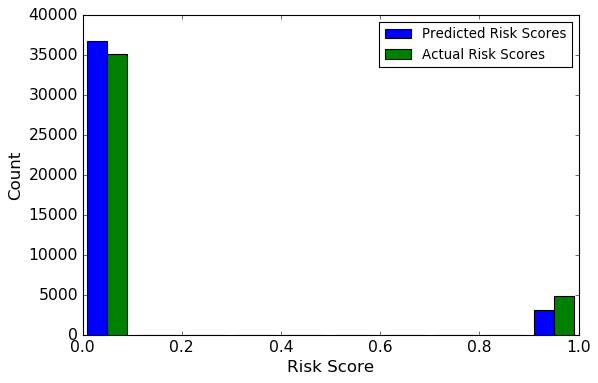

In [58]:
plt.hist([predicted_record_scores.Prediction, true_record_scores.Prediction] , label=["Predicted Risk Scores", "Actual Risk Scores"])
plt.legend()
plt.xlabel("Risk Score")
plt.ylabel("Count")
plt.show()

We can also judge the model confidence (using the standard deviation of the predictions):

Text(0, 0.5, 'Count')

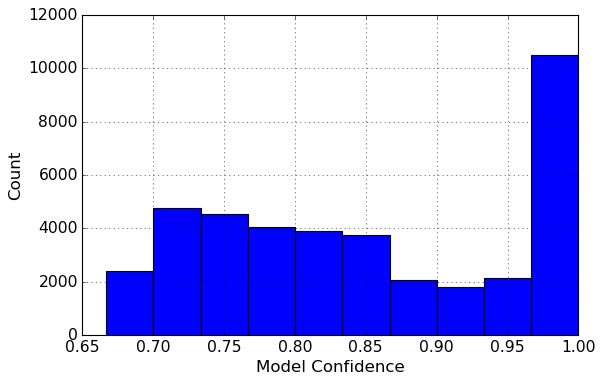

In [59]:
predicted_record_scores.Confidence.hist()
plt.xlabel("Model Confidence")
plt.ylabel("Count")

And the number of frames in which each record appears:

Text(0, 0.5, 'Count')

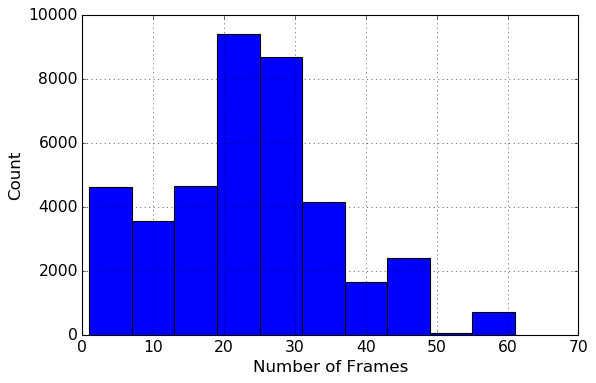

In [60]:
predicted_record_scores.OccurenceCount.hist()
plt.xlabel("Number of Frames")
plt.ylabel("Count")